# Scaling from data manifold dimension

This is a theory of neural scaling law, proposed by
* Sharma, Utkarsh, and Jared Kaplan. "Scaling laws from the data manifold dimension." The Journal of Machine Learning Research 23.1 (2022): 343-376.

According to this theory, a neural network, when trained to convergence, allocates its $N$ parameters in two parts:
* A fixed number of parameters that map the data to an intrinsic data manifold of dim $d$.
* All other parameters that handle pieces of this manifold. Loss $\propto$ the volume of each manifold piece.

They argued that the loss function should scale as $L \propto N^{-4/d}$ for cross-entropy and mean-square losses.




## Generating and measuring data manifold dimensions

Consider the space of all MNIST images. Each MNIST image is a 28x28 grayscale, so the total space is $\mathbb R^{28\times 28} = \mathbb R^{784}$.

However, as you may have seen in experiments with the VAE, most of the MNIST dataset "collapses" onto a much smaller subset of $\mathbb R^{784}$. This is the "(intrinsic) data manifold", with a dimension much smaller than $784$. Indeed, the very fact that the intrinsic dimension is small allows us to have meaningful "2D slices" of the dataset:

![](https://savadikarc.github.io/assets/vae_vis/mnist_manifold.png)

More images are shown [here](https://savadikarc.github.io/post/2020/01/30/vae_vis/), and can be regenerated in about 10 minutes with Google Colab GPU.

Real data can be expensive, though, which is why we often use "toy" datasets with known dimensions, generated by a known random process. For example, the following is the "Swiss roll" dataset. It is generated by first populating a 2D square $[0, 1]^2$, then use a function $f: \mathbb R^2 \to \mathbb R^3$ to "roll up" the square into 3D space.

![](https://upload.wikimedia.org/wikipedia/commons/b/b3/Isomap_on_Swiss_roll.png)


Instead of hand-designing Swiss rolls, we can automatically generate random data manifolds of known dimensions by random neural networks. The idea is simple: a randomly initialized neural network with $d$ inputs and $s$ outputs is nothing but a random function of type $\mathbb R^d \to \mathbb R^s$, and if $s > d$, then in general, the output dataset should fall on a smooth, low-dimensional data manifold.

## Generating data manifold by random neural networks

We consider the simplest data manifold: $\mathbb R^d$, affinely transformed, then embedded in $\mathbb R^n$, with $n > d$.

So, here is the neural network we will use, called "teacher network" because it implements the function that the "student network" will implement.

A teacher network has the following architecture:
* The number of neurons in each layer are: $[d, 9, 600, 600, 1]$
* It has 0 bias.
* The weights between layers are sampeled from $\mathcal N(0, m^{-1/2})$ , where $m$ is the input size of the layer (a form of He initialization).
* The activation function at the second (with 9 neurons) and last layers are identity. All other activation functions are ReLU.

The teacher network is used to generate a dataset $\{(x_i, y_i)\}_i$ in this way:
* Generate random gaussian vectors $\{t_i\}_i$ in $\mathbb R^d$, with mean $0$ and std $I_{d\times d}$.
* For each $t \in \{t_i\}_i$, push $t$ through the teacher network.
* Let $x \in \mathbb R^9$ be the teacher network activation at the second layer, with 9 neurons.
* Let $y \in \mathbb R$ be the teacher network output.

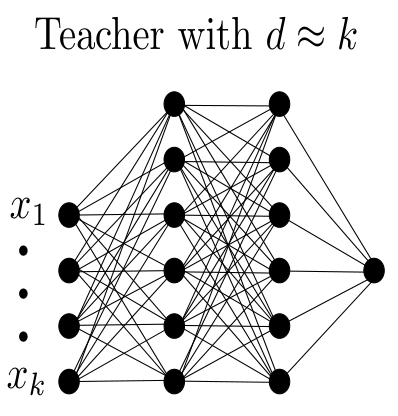

In [ ]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TeacherNetwork(nn.Module):
    def __init__(self, d):
        super(TeacherNetwork, self).__init__()
        self.d = d
        self.layers = [d, 100, 9, 600, 600, 1]

        # Initialize layers and weights
        fc_layers = []
        for i in range(len(self.layers) - 1):
            weight_scale = self.layers[i]**(-0.5)
            layer = nn.Linear(self.layers[i], self.layers[i+1], bias=False)
            nn.init.normal_(layer.weight, mean=0, std=weight_scale)
            fc_layers.append(layer)
        self.embed = nn.Sequential(
            fc_layers[0],
            nn.ReLU(),
            fc_layers[1])
        self.network = nn.Sequential(
            fc_layers[2],
            nn.ReLU(),
            fc_layers[3],
            nn.ReLU(),
            fc_layers[4]
        )

    def forward(self, x):
        return self.network(self.embed(x))

    def generate_dataset(self, size):
      with torch.no_grad():
          t = torch.randn(size, self.d, device=self.embed[0].weight.device)
          x = self.embed(t)
          y = self.network(x)
      return x, y

Let's see what the output of the random teacher network is like:

In [ ]:
import matplotlib.pyplot as plt

teacher = TeacherNetwork(5)
x = teacher.generate_dataset(100000)[1]
plt.hist(x.flatten().detach().numpy(), bins=50)
plt.title("Output")
plt.show()

The teacher neural network produces datasets $\{(x_i, y_i)\}_i$, where $x_i\in \mathbb R^9$, and $y_i \in \mathbb R$, so each data point is $(x_i, y_i)\in \mathbb R^{10}$, but this data manifold should have only dimension $\approx d < 10$. We can verify this by manifold dimension estimation package `scikit-dimension`.

In [ ]:
!pip install scikit-dimension

In [ ]:
import skdim
import numpy as np

d = 3
teacher = TeacherNetwork(d)
dataset_size = 20000
teacher.generate_dataset(size=dataset_size)
dataset = teacher.generate_dataset(dataset_size)

data_array = np.array(torch.cat((dataset[0], dataset[1]), 1))

danco = skdim.id.DANCo().fit(data_array)
lpca = skdim.id.lPCA().fit_pw(data_array, n_neighbors=100, n_jobs=1)

print("Expected intrinsic dimension:", d)
print("DANCo estimated intrinsic dimension:", danco.dimension_)
print("lPCA estimated mean intrinsic dimension:", np.mean(lpca.dimension_pw_))

## Learning data manifold by neural networks


According to the data manifold theory, if the data manifold has dimension $d$, then as we scale up a neural network with $N$ parameters, the MSE loss of a fully-trained network would scale like $L \sim N^{-\alpha}$, where $\alpha \approx 4/d$.

Let's test this.

First, we define the "student" neural network architecture:
* The number of neurons in each layer are: $[9, n, n, 1]$.
* The biases are initialized to 0.
* The weights between layers are sampeled from $\mathcal N(0, m^{-1/2})$, where $m$ is the input size of the layer (a form of He initialization).
* All activation functions are ReLU.

A simple computation shows that the network has exactly

$$N = (n+n+1) + (9n + n^2 + n) = n^2+12n + 1$$

parameters. Fortunately there is an automatic way to count it: `sum(p.numel() for p in self.parameters())`.

In [ ]:
class StudentNetwork(nn.Module):
    def __init__(self, n):
        super(StudentNetwork, self).__init__()
        self.n = n
        self.layers = [9, n, n, 1]

        # Initialize layers and weights
        self.fc_layers = nn.ModuleList()
        for i in range(len(self.layers) - 1):
            weight_scale = (self.layers[i] + self.layers[i+1])**(-0.5)
            layer = nn.Linear(self.layers[i], self.layers[i+1])
            nn.init.normal_(layer.weight, mean=0, std=weight_scale)
            nn.init.constant_(layer.bias, 0)  # Initialize biases to 0
            self.fc_layers.append(layer)

    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = nn.functional.relu(layer(x))
        x = self.fc_layers[-1](x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

n = 100
student = StudentNetwork(n)
print("Total number of parameters in the student network:", student.count_parameters())

### First student network

Let's train the first student network to convergence, to get a taste of it.

As described in the paper, the student network is trained to minimize MSE loss, by Adam optimizer, with each iteration defined by two parameters: Adam learning rate `lr`, and batch size `n_batch`.

Some side notes on the design choices. The precise choices are not that important, but I have tried plenty of them, and settled on something that can

* consistently reach $\leq 2\times$ the minimal loss
* takes about 1 minute per training run
* Enough to make my point.

How we do it:

* `AdamW` optimizer with `lr = 0.01`. This seems to me to work better than `Adam`, which is what the paper used.
* `OneCycle` learning rate scheduler.

The paper had this to say about how to train the networks:
> We use the ADAM optimizer Kingma and Ba (2014) with default settings except for the learning rate. In order to optimize effectively, we scanned over a grid of learning rates, and experimented with cosine, linear, and step-function learning rate schedules. We ended up using step function schedules for teacher/student experiments, and a constant learning rate for CIFAR10 and other image datasets, as these performed roughly as well or better than other choices. We did not find it necessary to vary the overall learning rate among different network sizes, but the schedules themselves were important for optimization.

In [ ]:
from tqdm import trange
from torch.optim.lr_scheduler import OneCycleLR

def trainer(teacher, student, lr, n_batch, n_steps, losses):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(student.parameters(), lr=lr)

    max_lr = 0.01
    total_steps = n_steps
    epochs = total_steps // n_batch
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, epochs=epochs)

    progress_bar = trange(n_steps)
    for step in progress_bar:
        x, y = teacher.generate_dataset(n_batch)
        x, y = x.cuda(), y.cuda()
        y_hat = student(x)

        optimizer.zero_grad()
        loss = criterion(y, y_hat)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (step + 1) % 100 == 0:
            progress_bar.set_postfix({"loss": f"{loss.item():.1e}"})
            losses.append(loss.item())
    return losses

In [ ]:
assert torch.cuda.is_available(), "Please turn on GPU accelerator. On Google Colab, it is Runtime -> Change runtime type -> GPU"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d = 10
n = 50
teacher = TeacherNetwork(d).cuda()
student = StudentNetwork(n).cuda()
losses = trainer(teacher, student, 0.01, 1000, 20_000, [])

In [ ]:
def plot_loss_curve(losses, d, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None
    ax.loglog((np.array(range(len(losses))) + 1) * 100, losses)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title(f"d = {d}, n = {n}")
    if fig is not None:
        return fig

plot_loss_curve(losses, d, n).show()

### Loss as a function of student parameter count

Now that we see the training converges, we can start studying the scaling laws. Specifically, we would like to reproduce plot 13 in the paper ("Scaling laws from the data manifold dimension"), which is a plot of the MSE loss $L$ as a function of $N$, the number of parameters in a student network.

Let's try doing it for $d=10$ first, which according to the paper should satisfy $L(N) \propto N^{-4/d} \approx N^{-0.4}$, where $N$ is the number of parameters of the student network, and $d$ is the intrinsic dimension of the data manifold.

In [ ]:
def log_interp_array(n_min, n_max, num_points):
    log_n_min = np.log10(n_min)
    log_n_max = np.log10(n_max)
    log_values = np.linspace(log_n_min, log_n_max, num_points)
    interpolated_values = 10**log_values
    return np.array(interpolated_values, dtype=int)

def design_student_n(N):
    # Since a student network with width n, has n^2+12n+1 parameters
    # To make it have N paratemers, we just need width sqrt(N+35)-6
    return int(np.sqrt(N + 35)) - 6

def design_student_Ns(N_min, N_max, num_points):
    Ns = log_interp_array(N_min, N_max, num_points=num_points)
    for i, N in enumerate(Ns):
        student = StudentNetwork(design_student_n(N))
        Ns[i] = student.count_parameters()
    return Ns

def run_experiment(d, Ns, max_lr=0.01, n_batch=1000, n_steps=20_000):
    Ls = []
    for i, N in enumerate(Ns):
        teacher = TeacherNetwork(d).cuda()
        student = StudentNetwork(design_student_n(N)).cuda()
        losses = trainer(teacher, student, max_lr, n_batch, n_steps, losses=[])
        Ls.append(losses)
    return Ls

In [ ]:
d = 10
Ns = design_student_Ns(500, 10**4, num_points=10)
Ls = run_experiment(d, Ns)
final_losses = [loss[-1] for loss in Ls]

In [ ]:
def plot_learning_curves(d, Ls, backend="plt", ax=None):
    if backend == "plt":
        if ax is None:

            fig, ax = plt.subplots(figsize=(10, 8))
        for i, losses in enumerate(Ls):
            ax.loglog((np.array(range(len(losses))) + 1) * 100, losses,
                      color="green",
                      alpha=0.05+(i/len(Ls))**1.7,
                      label=f"N={Ns[i]}")

        ax.set_xlabel("Step")
        ax.set_ylabel("Loss")
        ax.set_title(f"d = {d}")
        ax.legend()
    else:
        fig = go.Figure()

        for i, losses in enumerate(Ls):
            step = (np.array(range(len(losses))) + 1) * 100
            fig.add_trace(go.Scatter(x=step, y=losses,
                                    mode='lines',
                                    name=f'N={Ns[i]}',
                                    line=dict(color=f'rgba(0, 200, 0, {0.05+(i/len(Ls))**1.7})')))
        # Update layout
        fig.update_layout(
            xaxis_type="log",
            yaxis_type="log",
            xaxis_title="Step",
            yaxis_title="Loss",
            title=f"d = {d}",
            showlegend=True,
            legend=dict(orientation="h", x=0, y=1.1)
        )

    return ax

In [ ]:
plot_learning_curves(d, Ls, backend="plt")

Why does the learning curve appear jagged around step 5000? It's because of our choice of OneCycle scheduler, which peaks right around step 5000:

In [ ]:
def plot_lr_schedule(teacher, student, lr, n_batch, n_steps, losses):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(student.parameters(), lr=lr)

    max_lr = 0.01
    total_steps = n_steps
    epochs = total_steps // n_batch
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, epochs=epochs)

    lrs = []
    for step in range(total_steps):
        lr = scheduler.get_last_lr()
        lrs.append(lr)
        scheduler.step()

    plt.figure(figsize=(10, 6))
    plt.plot(range(total_steps), lrs)
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.show()

d = 10
n = 50
teacher = TeacherNetwork(d).cuda()
student = StudentNetwork(n).cuda()
plot_lr_schedule(teacher, student, 0.01, 1000, 20_000, [])

We see that the learning curves do trend downward very well over the training run. One might be tempted to wonder "What if we train further?", but this does not work, because we are using the `OneCycleLR` scheduler, and initializing the training run for longer would stretch out the scheduler, and we still end up with the same losses (I know, because I have tried), just slower.

For example, running for 20000 `OneCycleLR` steps with the student network of $N=10000$ would give us about $L = 0.0002$. Running for twice that long still gives us the same loss.

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, y0, alpha):
    return y0 / (x ** alpha)

def fit_power_law(Ns, Ls, d, ax=None):
    final_losses = [loss[-1] for loss in Ls]
    xs, ys = Ns, final_losses
    params, covariance = curve_fit(power_law, xs, ys, p0=[1.0, 1.0])

    y0, alpha = params

    x_fit = np.linspace(min(xs), max(xs), 100)
    y_fit = power_law(x_fit, y0, alpha)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(xs, ys)
    ax.plot(x_fit, y_fit, color='red', label=fr"$\alpha$ = {alpha:.2f}")
    ax.set_title(fr"$d = {d}, \frac{{4}}{{\alpha}} = {4/alpha:.2f}$")
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Parameter count')
    ax.set_ylabel('Loss')
    return ax

In [ ]:
fig, ax = fit_power_law(Ns, Ls, d)
fig.show()

Given the above scaling law, we can quite confidently predict that, if we were to train a student network with $5\times 10^4$ parameters, then it would have achieved loss $\sim 5 \times 10^{-5}$.

Yes, I made the above prediction without cheating. Let's see how well the prediction holds up...


In [ ]:
TeacherNetwork(10)

In [ ]:
Ns_extension = design_student_Ns(10**4, 10**5, num_points=5)
Ls_extension = run_experiment(d, Ns_extension)

In [ ]:
fig, ax = fit_power_law(Ns, Ls, d)
ax.scatter(Ns_extension, [loss[-1] for loss in Ls_extension], color="red")
fig.show()

Well, this is awkward. Perhaps the student network has plateaued in its performance, because the teacher network has only about $360k$ parameters, and the student network above already has 100k parameters.

 We can try to check that hypothesis by training a student network that has more parameters than the teacher. Let's say, 500k.

In [ ]:
Ns_large = design_student_Ns(10**5, 10**6, num_points=5)
Ls_large = run_experiment(d, Ns_large, n_steps=50_000)

In [ ]:
fig, ax = fit_power_law(Ns, Ls, d)
ax.scatter(Ns_large, [loss[-1] for loss in Ls_large], color="red")
fig.show()

As we see, the loss really have plateaued.

This demonstrates another important use of scaling laws: as predictive diagnostics. If you can predict loss, then you can be surprised, and if you can be surprised, you can check your assumptions and do better next time.

## The end of scaling laws

Looking at Figure 13, we see that if the intrinsic dimension is small, then the scaling law can actually saturate. That is, the student network can run out of things to learn.

In [ ]:
d = 2
Ns = design_student_Ns(500, 10**4, num_points=10)
Ls = run_experiment(d, Ns)
final_losses = [loss[-1] for loss in Ls]

In [ ]:
fig, ax = fit_power_law(Ns, Ls, d)
fig.show()

Whoops, we see that the student network is too strong for the teacher and is essentially fitting random noise at the point. We need to turn down the experiment.

## Running the whole experiment

Alright! We have successfully reproduced one subfigure of Figure 13 of the paper. Time to attempt to reproduce the entire Figure 13. This shouldn't take much effort. Just plug in the previous code and let it run.

This should be finished in about 50 minutes on Google Colab.

In [ ]:
experiment_setup = {
    2: (200, 2000),
    4: (200, 2000),
    6: (200, 2000),
    8: (500, 10**4),
    10: (500, 10**4),
    12: (500, 10**4),
    14: (1000, 2*10**4),
    16: (1000, 2*10**4),
    18: (1000, 2*10**4)
}

Ns_dictionary = {}

Ls_dictionary = {}

In [ ]:
for d in experiment_setup.keys():
    N_min, N_max = experiment_setup[d]
    print(f"d = {d}, N = ({N_min}, {N_max})")
    Ns = design_student_Ns(N_min, N_max, num_points=10)
    Ls = run_experiment(d, Ns)
    Ns_dictionary[d] = Ns
    Ls_dictionary[d] = Ls

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(20, 32))

for i, d in enumerate(experiment_setup.keys()):
    Ns = Ns_dictionary[d]
    Ls = Ls_dictionary[d]
    row = i // 3 * 2
    col = i % 3

    plot_learning_curves(d, Ls, backend="plt", ax=axs[row, col])
    fit_power_law(Ns, Ls, d, ax=axs[row+1, col])

plt.tight_layout()
plt.show()

In summary, the agreement between $d$ and $\frac 4\alpha$ is fairly good for $d \in [4, 6, 8, 10, 12, 14, 16]$. For $d=2$, the student network has clearly overfitted, as we can see that the MSE loss has reached down to `1e-6`.

The agreement have also broken down at $d=18$. I believe that this is because the dataset has finally became complex enough that, during training, the student networks could not reach convergence.

The paper in Table 1 reported their training setup:

| training steps | batch size | learning rate (ADAM) |
| -- | -- | -- |
| 0-200k |  200 | 0.01 |
| 200-220k | 1000 | 0.01 |
| 220-240k | 4000 | 0.001 |

Which is something we cannot afford, as it would take over 9 hours on Colab even just to run all the experiments perfectly without intervention. I have actually tried doing the training run for $d=18$ with the specified optimizers. The resulting scaling curve actually looks even more different from the theoretical prediction as above.

So in short, don't bother with it.